## Garbage Classification using Transfer Learning

### CS-GY-6923 Machine Learning
#### Chirag Mahajan
#### NET ID: cm6591

##### Motivation

In the rapidly evolving field of machine learning, the ability to effectively classify objects into multiple categories is critical for a wide range of applications, from image recognition to customer segmentation. Traditional machine learning models often require extensive datasets and considerable training time to achieve high accuracy. However, many real-world scenarios do not have the luxury of large, annotated datasets. This limitation necessitates innovative approaches to leverage existing resources to maximize performance. Transfer learning emerges as a compelling solution in this context, enabling the use of models pre-trained on large datasets to be fine-tuned for specific, smaller-scale tasks. This approach not only saves time and computational resources but also significantly improves the feasibility and accuracy of classification tasks in data-constrained environments.

##### Aim of the Project
The primary aim of this project is to demonstrate the efficacy of transfer learning in multi-class classification tasks across different domains. By adapting a pre-trained model to new categories, I intend to achieve high accuracy in object classification with limited data. The project will involve selecting an appropriate pre-trained model, preparing the dataset for transfer learning, and fine-tuning the model to our specific classification needs.

In this project, the challenge of multi-class classification is explored, where the objective is the accurate assignment of each object to one of several predefined categories. Our goal is to achieve high precision in the correct categorization of each object.

Transfer learning is a machine learning strategy where a pre-trained model is leveraged. This technique involves a model that has been previously trained on one dataset being adapted for use on a different dataset. Particularly effective at enhancing classification accuracy when the dataset is relatively small, transfer learning serves as a powerful tool for improving model performance across diverse applications.

### Import Libraries

In [1]:
import os
import shutil
import splitfolders
from pathlib import Path
import imghdr
import numpy as np
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt 
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from keras.models import Sequential
from tensorflow.keras import layers

In [4]:
experiment_name = "Transfer Learning"

### Description of the dataset

The set used has about 22,000 images of various types of waste, divided into 10 different categories - metal, glass, biological waste, etc.

### Data Preprocessing

In [5]:
data_dir = '/Users/chiragmahajan/Documents/Coding/garbage_dataset'

The Tensorflow library that I am going to use does not support some image formats, in addition, the dataset may have corrupted or non-image files. Let's pre-clean the dataset.

In [6]:
data_dir = '/Users/chiragmahajan/Documents/Coding/garbage_dataset'  # Make sure to specify your directory path
count = 0
image_extensions = [".png", ".jpg", ".jpeg"]  # Added .jpeg as it's a common format
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]

for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)  # Remove file if not an image
            count += 1  # Increment count for files removed
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)  # Remove file if type not accepted by TensorFlow
            count += 1  # Increment count for files removed

print(f"Removed {count} images")

Removed 0 images


To train the model, I will need to divide the data into several samples, so I will create folders for them.

In [7]:
os.mkdir('data')

In [8]:
os.chdir('data')

In [9]:
os.getcwd()

'/Users/chiragmahajan/Documents/Coding/data'

In [10]:
os.mkdir('train')
os.mkdir('test')
os.mkdir('val')

In [11]:
os.chdir('/Users/chiragmahajan/Documents/Coding')

In [12]:
os.getcwd()

'/Users/chiragmahajan/Documents/Coding'

Let's set a random value for reproducibility of the result. In particular, when splitting the dataset randomly (as in the following block of code), a fixed SEED value ensures that we get exactly the same split of data next time.

In [13]:
SEED = 42

Let's divide the data from the dataset into three folders - for training and test samples.

In [14]:
splitfolders.ratio("/Users/chiragmahajan/Documents/Coding/garbage_dataset", output = 'data', seed = SEED, ratio = (.8,.1,.1), group_prefix = None)

Copying files: 23577 files [00:08, 2733.28 files/s]


In [15]:
data_dir

'/Users/chiragmahajan/Documents/Coding/garbage_dataset'

Setting paths to training and test data.

In [16]:
train_path = '/Users/chiragmahajan/Documents/Coding/data/train'
val_path = '/Users/chiragmahajan/Documents/Coding/data/val'
test_path = '/Users/chiragmahajan/Documents/Coding/data/test'

Visualization of data from dataset

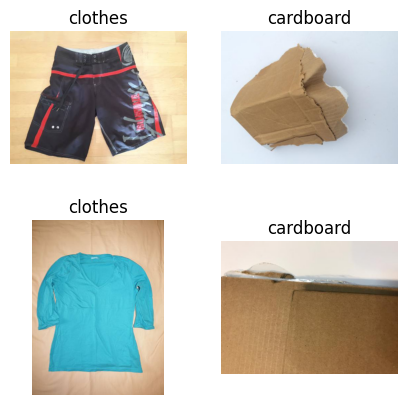

In [17]:
fig, axes = plt.subplots(2, 2, figsize = (5,5))
axes = axes.ravel() 

for i in np.arange(0, 4): 

    category = random.choice(os.listdir(train_path))
    class_dir = os.path.join(train_path, category)

    image = random.choice(os.listdir(class_dir))
 
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(category) 
    axes[i].axis('off')

Let's look at the distribution of data between classes.

In [18]:
total = 0
for category in os.listdir(train_path):
    count= 0
    for image in os.listdir(train_path + "/" + category):
        count += 1
        total +=1
    print(str(category).title() + ": " + str(count))  
print(f"\nTotal number of train images: {total}")

Paper: 2168
Clothes: 4260
Metal: 1494
Cardboard: 1864
Trash: 667
Glass: 3270
Biological: 788
Battery: 756
Plastic: 2011
Shoes: 1581

Total number of train images: 18859


It is noticeable that in some classes the number of images differs several times. Let's visualize the distribution of classes for clarity.

In [19]:
# class names
class_names = sorted(os.listdir(train_path))
class_names

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [20]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[756, 788, 1864, 4260, 3270, 1494, 2168, 2011, 1581, 667]

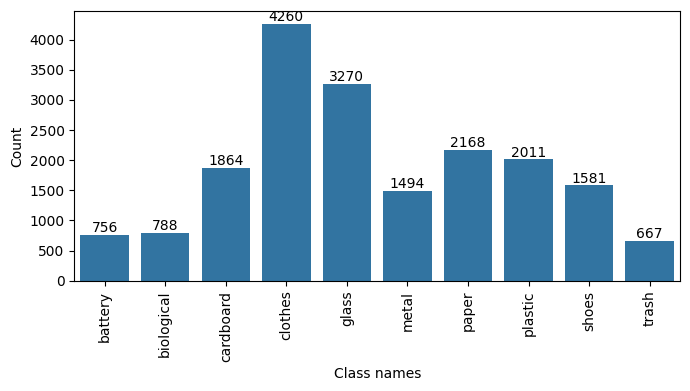

In [21]:
# Creating DataFrame
DF = pd.DataFrame({
    'Class names': class_names,
    'Count': class_dis
})

# Creating the bar plot
plt.figure(figsize=(7, 4))
ax = sns.barplot(x='Class names', y='Count', data=DF)
ax.bar_label(ax.containers[0])

# Set x-tick labels with fixed ticks using the FixedLocator
from matplotlib.ticker import FixedLocator
ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

A situation where one or more classes contain a significantly larger number of images is called class imbalance. In our situation, it is natural and determined by the specifics of the data. Thus, there are many more varieties of clothing or glass objects than batteries. However, this may negatively affect the training results of the model and cause it to be biased towards the largest class (that is, it will be much worse at classifying smaller classes). There are different approaches to solving this problem, the applicability of which depends on the problem being solved. We will use the method of insufficient sampling (random undersampling), which consists of randomly excluding some examples from large classes.

Excluding some random images from the training data

In [22]:
for category in os.listdir(train_path):
    count = 0
    delete = 0
    for image in os.listdir(train_path + '/'  + category):
        count += 1
        while count > 1000:
            random_image = random.choice(os.listdir(train_path + '/' + category)) 
            delete_image = train_path + '/'  + category +  '/' + random_image
            os.remove(delete_image)
            delete+=1
            count-=1
           
    print(f'Deleted {delete} in {category}')

Deleted 1168 in paper
Deleted 3260 in clothes
Deleted 494 in metal
Deleted 864 in cardboard
Deleted 0 in trash
Deleted 2270 in glass
Deleted 0 in biological
Deleted 0 in battery
Deleted 1011 in plastic
Deleted 581 in shoes


We limited the number of images in large classes to 1000. Let's see what the class distribution looks like now.

In [23]:
class_dis = [len(os.listdir(train_path + f"/{name}")) for name in class_names]
class_dis

[756, 788, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 667]

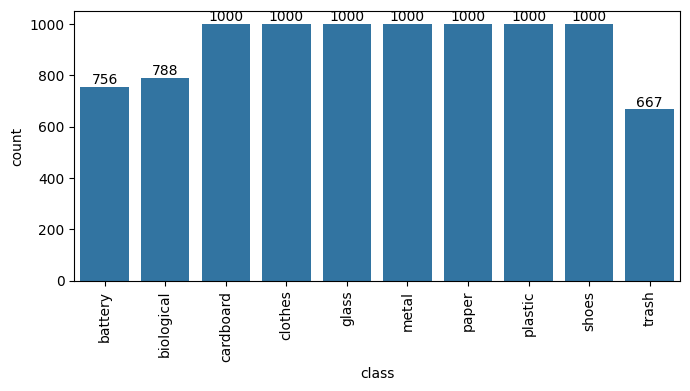

In [24]:
# Creating the DataFrame
DF = pd.DataFrame({
    'class': class_names,
    'count': class_dis
})

# Plotting
plt.figure(figsize=(7, 4))
ax = sns.barplot(x='class', y='count', data=DF)
ax.bar_label(ax.containers[0])

# Fixing the number of x-tick positions and setting labels with rotation
ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
ax.set_xticklabels(class_names, rotation=90)  # Explicitly setting class names as tick labels

plt.tight_layout()
plt.show()

The data distribution now looks much better, although some image classes are still quite sparse. We will try to solve this problem using augmentation methods that we integrate into the model.

In [25]:
data_path = '/Users/chiragmahajan/Documents/Coding/data'

To train a neural network, it is necessary to ensure unification of image sizes. To do this, let’s find the average width and height of images in the entire dataset.

In [26]:
width = []
height = []
from PIL import Image
import numpy as np

for dirname in os.listdir(data_path):
    for category in os.listdir(data_path + '/' + dirname):
        for image in os.listdir(data_path + '/' + dirname + '/' + category):
            img = Image.open(data_path + '/' + dirname + '/' + category + '/' + image)
            width.append(img.width)
            height.append(img.height)

print('Mean width: {:.4f}'.format(np.mean(width)))
print('Mean Height: {:.4f}'.format(np.mean(height)))

Mean width: 415.6046
Mean Height: 394.9972


Let's set the size of the input data (image size) taking into account the found average values.

In [27]:
IMG_SIZE = (400, 400)

Let's set the size of the data package for loading images into the model in parts.

In [28]:
BATCH_SIZE = 32

Previously, we divided the entire amount of data into three sets. Now you need to prepare them for working with the model - distribute them into packages and add labels to them. Data packets generated from the train folder, constituting 80% of the total number of images, will be used to train the model, from the val(10%) folder - for checking during training and adjusting parameters, and from the test folder - to evaluate the accuracy of the model on new data not used during training.

In [30]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path,
                                                         image_size=IMG_SIZE,
                                                         label_mode='categorical',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         seed=SEED)

Found 9211 files belonging to 10 classes.


In [31]:
test_data = tf.keras.utils.image_dataset_from_directory(test_path,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical',
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False)

Found 2365 files belonging to 10 classes.


In [32]:
validation_data = tf.keras.utils.image_dataset_from_directory(val_path,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              seed=SEED)

Found 2353 files belonging to 10 classes.


### Building the model

When selecting a model, we examined the classification models available in Keras with pre-trained weights on the public ImageNet dataset, which includes about 1000 categories of various images (https://keras.io/api/applications/). For our task, the most important parameter is the classification accuracy. Based on the accuracy values presented in the table (acc1, percentage of correct answers), the EfficientNetV2S model, which has 88 layers, was selected. Although the EfficientNetV2M and EfficientNetV2L models have higher accuracy, they have significantly higher weights.

Loading the model

In [34]:
base_model = tf.keras.applications.EfficientNetV2S(include_top=False,
                                                   weights='imagenet', 
                                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

Let's see what the architecture of the pretrained model looks like.

In [35]:
base_model.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 400, 400, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 200, 200, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 200, 200, 24)         96        ['stem_conv[0][0]']           
 n)                                                                                

The architecture of the model we are using already has a Rescale layer, so we may not include an additional image normalization layer in our model.

Let's freeze all layers of the pretrained model so that its parameters do not change during training.

In [36]:
base_model.trainable = False

Let's create a data augmentation layer to improve classification accuracy. This layer is active only during model training.

In [37]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.RandomRotation(0.2), 
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomHeight(0.2),
                                         tf.keras.layers.RandomWidth(0.2),],
                                         name ="data_augmentation")

Let's see how this layer works with images from the training set.

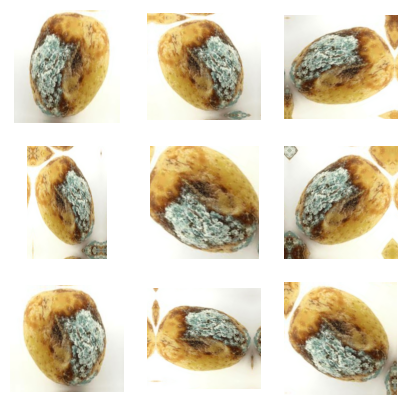

In [39]:
for image, _ in train_data.take(1):  
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Let's combine the model with the augmentation layer, and also add several layers:

GlobalAveragePooling2D layer, which calculates the arithmetic average over all channels to combine feature maps
A fully connected layer with 128 neurons and a Dropout layer, which excludes some neurons from the previous fully connected layer with a given probability, thereby reducing the possible effect of overfitting.
Output fully connected layer with the number of outputs corresponding to the number of classes of our data.

In [41]:
name="EfficientNetV2S"
data_augmentation_layer = tf.keras.layers.Lambda(lambda x: data_augmentation(x))

EfficientNetV2S_model = tf.keras.Sequential([
    tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name="input_layer"),
    data_augmentation_layer,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
], name="EfficientNetV2S")

For training, we will define a loss function, an optimizer, and a tracked accuracy metric.

In [42]:
EfficientNetV2S_model.compile(loss='categorical_crossentropy',
                              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 0.001),
                              metrics=['accuracy'])

Let's look at the structure of our model.

In [43]:
EfficientNetV2S_model.summary()

Model: "EfficientNetV2S"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, None, 3)     0         
                                                                 
 efficientnetv2-s (Function  (None, 13, 13, 1280)      20331360  
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)            

The summary already shows the advantage of using a pre-trained model - out of more than 20 million parameters, only 165 thousand are trainable, which will significantly reduce training time.

While training the models, we will use a callback function to stop training when the metrics being tracked stop improving. After this, we will save the trained model and weights for further use.

In [44]:
def log_to_tensorboard(epoch, logs):
    train_writer.add_scalar('loss', logs['loss'], epoch)
    train_writer.add_scalar('accuracy', logs['accuracy'], epoch)
    
    # Use get method with a default value of None to avoid KeyError
    val_loss = logs.get('val_loss', None)
    val_accuracy = logs.get('val_accuracy', None)
    
    if val_loss is not None:
        test_writer.add_scalar('val_loss', val_loss, epoch)
    if val_accuracy is not None:
        test_writer.add_scalar('val_accuracy', val_accuracy, epoch)


# Creating a Callback Function
def create_callback(model_name):
    
    # termination of training when accuracy does not improve within 3 epochs
    early_stop = tf.keras.callbacks.EarlyStopping(patience=3,
                                                monitor="val_loss",
                                                mode="min",
                                                verbose=1)

    # decrease in learning rate when the error rate does not decrease over 2 epochs
    reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                              factor=0.2,
                                                              patience=2,
                                                              verbose=1,
                                                              min_lr=0.00001)

    log_to_tensorboard_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: log_to_tensorboard(epoch, logs))
    # saving model
    check_model = tf.keras.callbacks.ModelCheckpoint(model_name + ".h5",
                                                   monitor="val_accuracy",
                                                   mode="max",
                                                   save_best_only=True)
    callback = [early_stop, reduce_learning_rate, check_model, log_to_tensorboard_callback]
    return callback

In [45]:
EfficientNetV2S_callback = create_callback(name)

Let's set the number of training epochs.

In [46]:
EPOCH=20

Let's train the model.

In [47]:
import time
start_time = time.time()
EfficientNetV2S_history = EfficientNetV2S_model.fit(train_data, 
                                                    epochs=EPOCH, 
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=validation_data, 
                                                    validation_steps=len(validation_data),
                                                    callbacks=EfficientNetV2S_callback)

Epoch 1/20
288/288 [==============================] - 696s 2s/step - loss: 0.4553 - accuracy: 0.8608 - val_loss: 0.2047 - val_accuracy: 0.9358 - lr: 0.0010
Epoch 2/20
288/288 [==============================] - 690s 2s/step - loss: 0.2626 - accuracy: 0.9153 - val_loss: 0.1674 - val_accuracy: 0.9482 - lr: 0.0010
Epoch 3/20
288/288 [==============================] - 715s 2s/step - loss: 0.2152 - accuracy: 0.9300 - val_loss: 0.1476 - val_accuracy: 0.9545 - lr: 0.0010
Epoch 4/20
288/288 [==============================] - 694s 2s/step - loss: 0.1989 - accuracy: 0.9337 - val_loss: 0.1409 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 5/20
288/288 [==============================] - 703s 2s/step - loss: 0.1745 - accuracy: 0.9427 - val_loss: 0.1418 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 6/20
288/288 [==============================] - 688s 2s/step - loss: 0.1535 - accuracy: 0.9469 - val_loss: 0.1399 - val_accuracy: 0.9596 - lr: 0.0010
Epoch 7/20
288/288 [==============================] - 696s 2s/st

Based on the training history, you can evaluate the effectiveness of using our callback function - after reducing the learning speed, the errors also decreased.

Let's look at the model training schedules.

In [48]:
end_time = time.time()
training_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(training_time))
EfficientNetV2S_model.save("/Users/chiragmahajan/Documents/Coding/garbage-classification.h5")

Total training time: 14125.53 seconds


In [50]:
EfficientNetV2S_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [51]:
# Function for displaying training graphs
def plot_loss_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

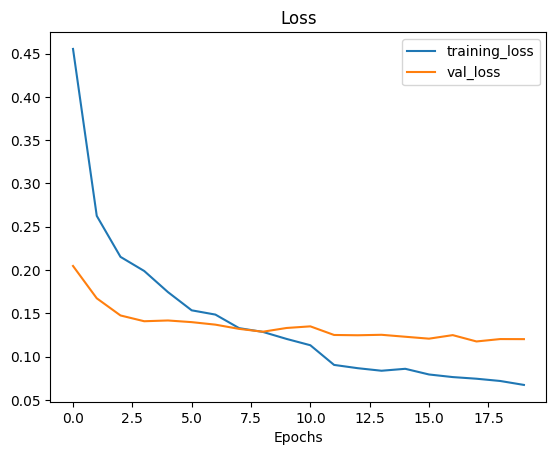

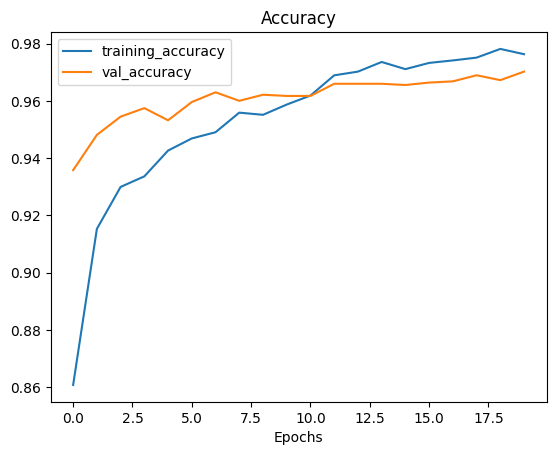

In [52]:
plot_loss_curves(EfficientNetV2S_history)

The learning curves look a little jumpy, but the dynamics look pretty good, there is a decrease in learning losses and an increase in testing accuracy.

### Model Evaluation

We use a set of test data to evaluate the accuracy of the model on new data.

In [53]:
test_loss, test_accuracy = EfficientNetV2S_model.evaluate(test_data, verbose=0)

In [54]:
print("Test Loss: {:.5f}".format(test_loss))
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

Test Loss: 0.10227
Test Accuracy: 97.55%


Given the limited data set, we obtained a good accuracy of 97%.

Let's look at the main classification metrics.

In [55]:
pred_probs = EfficientNetV2S_model.predict(test_data, verbose=1)

74/74 [==============================] - 138s 2s/step


In [56]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [57]:
y_labels = []
for images, labels in test_data.unbatch(): 
    y_labels.append(labels.numpy().argmax()) 
y_labels[:10] 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since the images in the test dataset were not shuffled, all the output labels correspond to the same class.

In [58]:
print('Classification Report \n')
target_names = class_names
print(classification_report(y_labels, pred_classes, target_names=target_names))

Classification Report 

              precision    recall  f1-score   support

     battery       0.99      0.94      0.96        95
  biological       0.99      0.99      0.99        99
   cardboard       0.98      0.97      0.98       234
     clothes       1.00      0.99      0.99       533
       glass       0.97      0.96      0.97       410
       metal       0.93      0.99      0.96       188
       paper       0.98      0.99      0.98       271
     plastic       0.95      0.95      0.95       252
       shoes       0.98      0.98      0.98       199
       trash       0.98      0.96      0.97        84

    accuracy                           0.98      2365
   macro avg       0.97      0.97      0.97      2365
weighted avg       0.98      0.98      0.98      2365



* The “Precision” column shows the percentage of correct predictions among all predictions for a particular class.
* The "Recall" column shows the percentage of images of a particular class that were predicted by the model to belong to that class.
* Column “F1” shows what percentage of model predictions were correct.
* The "Support" column shows how many images of each class were in the test dataset.

From the summary of metrics it is clear that the model classifies plastic worst of all, and best of all - things and various biological waste. However, despite the small data set, the model shows excellent performance in terms of Precision, Recall and F1 scores.

We visualize the error matrix to clearly see the correctness of class definitions.

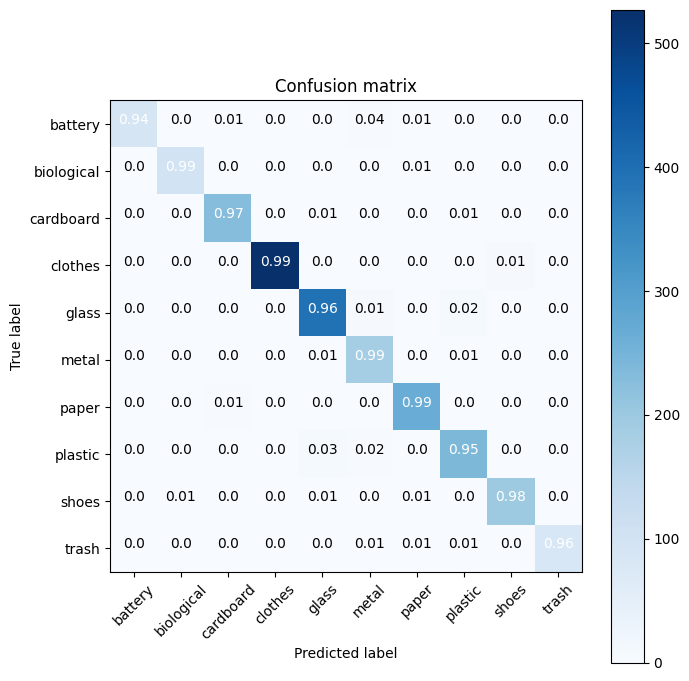

In [59]:
import itertools

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)
    cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_labels, pred_classes)
plot_confusion_matrix(cm, class_names)

The rows of the matrix are responsible for the class predicted by the model, and the columns are for the actual class. From the error matrix, it is noticeable that in general the model’s errors are very small, although it sometimes incorrectly predicts categories, for example, it confuses plastic and glass.

Visualizing several model predictions.

In [60]:
def pred_random_images(model_name, folder_path, class_names):
    plt.figure(figsize=(17, 10))
    for i in range(3):
        class_name = random.choice(class_names)
        filename = random.choice(os.listdir(folder_path + "/" + class_name))
        filepath = folder_path + "/" + class_name + "/" + filename
    
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE[0], IMG_SIZE[1]])
     #  img = img/255.
        pred_prob = model_name.predict(tf.expand_dims(img, axis=0), verbose=0) 
        pred_class = class_names[pred_prob.argmax()] 

  # Plot the image(s)
        plt.subplot(1, 3, i+1)
        plt.imshow(img/255.)
        if class_name == pred_class: 
            title_color = "g"
        else:
            title_color = "r"
        plt.title(f"Class: {class_name},\n Pred: {pred_class},\n Prob: {pred_prob.max():.2f}", c=title_color)
        plt.axis(False);

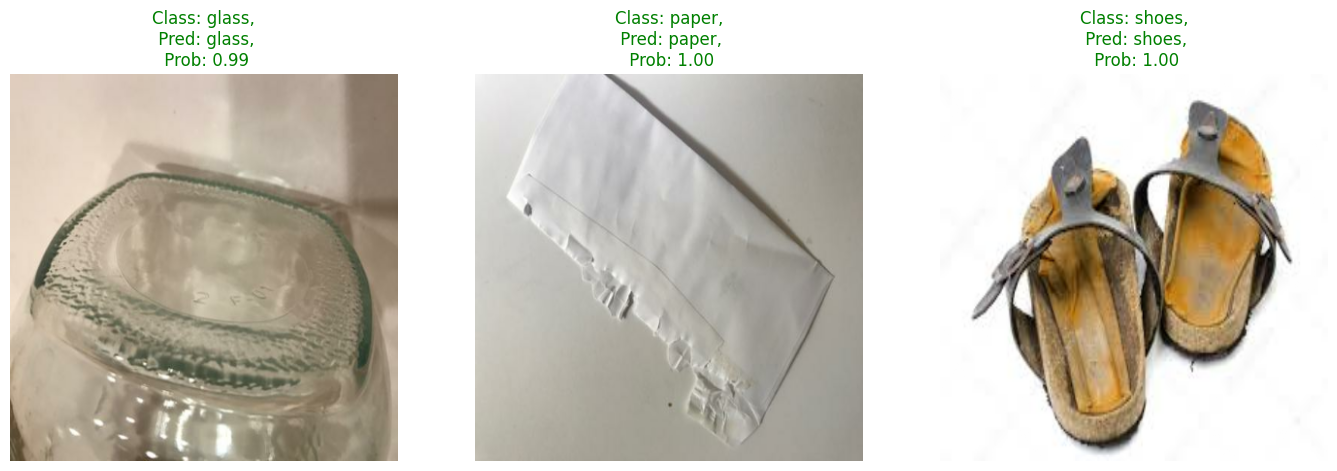

In [61]:
pred_random_images(EfficientNetV2S_model, test_path, class_names)

#### Advantages of using EfficientNetV2S Model:

**1. High Accuracy and Performance Metrics:**
The training and validation accuracy are notably high, with the final validation accuracy exceeding 97%. This is a strong indicator of the model's ability to generalize well to new, unseen data.
The classification report shows exceptional precision, recall, and F1-scores across all categories, indicating that the model is not only accurate overall but also balanced across different types of garbage.

**2. Effective Learning Dynamics:**
The loss curves demonstrate effective learning, with both training and validation losses decreasing steadily and converging. This suggests that the model is learning effectively without overfitting, as the validation loss decreases in tandem with the training loss.
The model benefits from advanced optimization techniques like the ReduceLROnPlateau, which adjusts the learning rate in response to validation loss plateaus, enhancing the learning efficiency.

**3. Robustness in Classification Across Categories:**
The confusion matrix shows high true positive rates across the board with very few misclassifications, indicating that the model is robust and reliable across diverse categories of waste.
The high performance in classes with potentially similar features (like plastic and glass) suggests that the model's depth and architecture allow it to discern subtle differences effectively.

**4. Real-World Applicability:**
The sample predictions demonstrate the model's practical effectiveness in real-world scenarios. It accurately classifies diverse objects with high confidence, which is crucial for applications in waste management and recycling industries.

**5. Efficiency and Scalability:**
EfficientNetV2S, designed for efficiency, allows you to achieve higher accuracy without proportionally increasing computational costs. This makes the model scalable and applicable to larger datasets or real-time applications without requiring exorbitant resources.

**6. Advanced Feature Extraction:**
The EfficientNetV2S architecture leverages a compound scaling method that optimally increases the depth, width, and resolution of the network layers. This enables the model to learn more complex, abstract representations of the input data, which is reflected in the high accuracy and the detailed feature extraction capabilities seen in the results.

### Baseline Model

A baseline model is typically a simple yet reasonably effective model that serves as a starting point for comparison when you're developing more complex models. For image classification tasks, a simple Convolutional Neural Network (CNN) often serves well as a baseline model.

In [62]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_dataset(data_dir, batch_size=32):
    """ Load data and infer input shape and number of classes from the dataset directory. """
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    # Assuming the images are in subdirectories under 'data_dir', and each subdirectory's name is a class label
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(150, 150),  # You can adjust the target size here
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'  # Set as training data
    )
    
    validation_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(150, 150),  # Make sure to use the same target size for validation data
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'  # Set as validation data
    )

    return train_generator, validation_generator

def build_simple_cnn(input_shape, num_classes):
    """ Build a simple CNN model based on the input shape and number of classes. """
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Example usage
train_gen, val_gen = load_dataset(data_dir)
input_shape = train_gen.image_shape
num_classes = len(train_gen.class_indices)

model = build_simple_cnn(input_shape, num_classes)
model.summary()

Found 18865 images belonging to 10 classes.
Found 4712 images belonging to 10 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                   

Found 18865 images belonging to 10 classes.
Found 4712 images belonging to 10 classes.
Epoch 1/10
590/590 [==============================] - 86s 145ms/step - loss: 1.7848 - accuracy: 0.3698 - val_loss: 1.3993 - val_accuracy: 0.5195
Epoch 2/10
590/590 [==============================] - 87s 148ms/step - loss: 1.4079 - accuracy: 0.5149 - val_loss: 1.1505 - val_accuracy: 0.6280
Epoch 3/10
590/590 [==============================] - 86s 146ms/step - loss: 1.2337 - accuracy: 0.5748 - val_loss: 1.0646 - val_accuracy: 0.6553
Epoch 4/10
590/590 [==============================] - 86s 146ms/step - loss: 1.1289 - accuracy: 0.6134 - val_loss: 0.9324 - val_accuracy: 0.7003
Epoch 5/10
590/590 [==============================] - 88s 149ms/step - loss: 1.0075 - accuracy: 0.6552 - val_loss: 0.9270 - val_accuracy: 0.7082
Epoch 6/10
590/590 [==============================] - 87s 147ms/step - loss: 0.9021 - accuracy: 0.6874 - val_loss: 0.8389 - val_accuracy: 0.7398
Epoch 7/10
590/590 [=======================

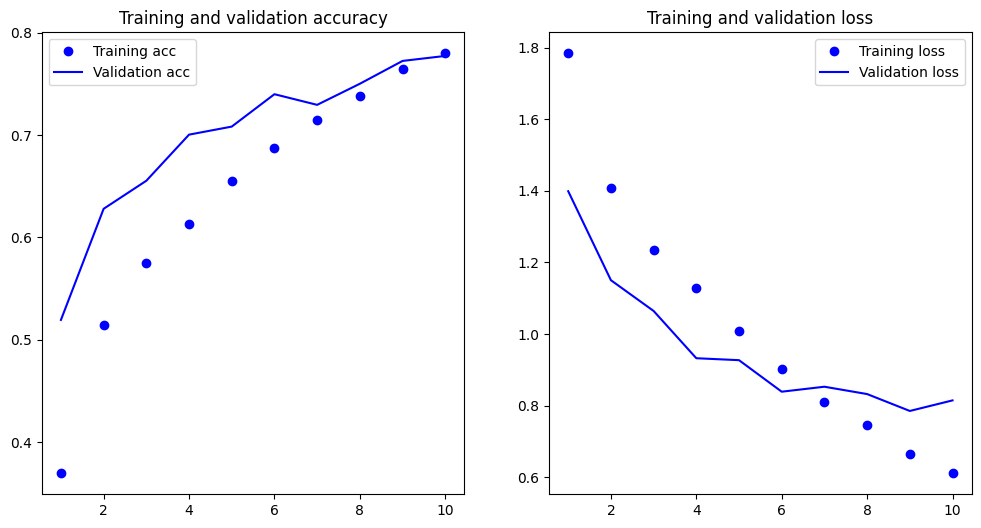

In [63]:
import tensorflow as tf

def train_and_evaluate(model, train_generator, validation_generator, epochs=10):
    """ Train the model and evaluate its performance. """
    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        verbose=1
    )
    
    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(validation_generator)
    print(f"Validation Accuracy: {val_accuracy:.2f}")
    
    return history, val_accuracy

# Load your dataset
train_gen, val_gen = load_dataset(data_dir)

# Build the model
input_shape = train_gen.image_shape
num_classes = len(train_gen.class_indices)
model = build_simple_cnn(input_shape, num_classes)

# Train and evaluate the model
history, validation_accuracy = train_and_evaluate(model, train_gen, val_gen, epochs=10)

# Optionally, plot the training and validation accuracy and loss over epochs
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)


**Training and Validation Accuracy:**

Observation: The training accuracy consistently increases, which is a good sign that the model is learning from the training data. However, the validation accuracy, despite improving, shows some fluctuation and does not reach the same level as the training accuracy.
Interpretation: This discrepancy could indicate that the model is beginning to overfit the training data. Overfitting happens when a model learns the details and noise in the training data to an extent that it negatively impacts the performance of the model on new data (i.e., the validation data).

**Training and Validation Loss:**

Observation: The training loss decreases smoothly, which aligns with the improvement in training accuracy. On the other hand, the validation loss decreases but with some fluctuations, particularly in the early epochs.
Interpretation: The validation loss generally follows a downward trend which is positive, yet the fluctuations and the gap between training and validation loss towards the end of training again suggest potential overfitting.

**Analysis of Current Results:**

Training and Validation Accuracy:

The training accuracy improves steadily, which is positive, but the validation accuracy, despite increasing, shows some signs of variance and does not achieve an exceptionally high score (peaking around 0.78). This suggests that while the model learns well on training data, its ability to generalize to new data could be improved.

Training and Validation Loss:

The training loss decreases nicely, which is expected, but the validation loss, although decreasing, shows fluctuations and doesn't decrease as steadily or as low as one might aim for optimal performance.

These points suggest a few potential issues, including:

Overfitting: Where the model learns the training data well but does not perform equivalently on unseen data.
Model Capacity: The current model may not have sufficient capacity to capture the complexity of the data or might be too simplistic.

**Case for EfficientNetV2S (Transfer Learning):**

**Higher Model Complexity and Capability:** EfficientNetV2S is designed to achieve excellent performance while being efficient in terms of computational cost. It scales up from baseline EfficientNets which have shown state-of-the-art performance across various tasks. This increased complexity and capability can capture more intricate patterns in the data, potentially leading to better generalization on validation or test sets.

**Pre-trained Weights:** EfficientNetV2S comes with pre-trained weights on ImageNet, which has a large and diverse set of images. Utilizing these weights through transfer learning provides a significant head start, as the model has already learned a variety of features from a wide range of images. This can particularly boost performance in tasks where the dataset is relatively small or not diverse enough to train such a deep model from scratch.

**Adaptive to Various Resolutions:** EfficientNet architectures are designed to perform well across a range of resolutions, making them adaptable to different input sizes without significant loss of accuracy. This adaptability can be particularly beneficial if your garbage classification task involves images of varying quality and resolutions.

**Efficiency:** Despite its complexity, EfficientNetV2S is optimized for both accuracy and efficiency (hence the name). It uses compound scaling methods (scaling depth, width, and resolution in a principled way) which makes it computationally efficient. This means you can achieve better performance without a proportional increase in computational cost.

**Better Generalization:** Given the variance and potential overfitting indicated in your baseline model, EfficientNetV2S's advanced regularization and normalization techniques might improve generalization, leading to more stable training and validation curves.